<a href="https://colab.research.google.com/github/OJoaoSP/Scraping-FII/blob/main/Analise%20de%20Fii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL - Scraping

## Import de biblioteca e lendo a página 

In [ ]:
import pandas as pd
import html5lib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup
%matplotlib inline
import time

In [ ]:
url = "https://www.fundsexplorer.com.br/ranking"

#Informações para fingir ser um navegador
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
#juntamos tudo com a requests
r = requests.get(url, headers=header)
df = pd.read_html(r.text)
dados = pd.DataFrame(df[0])




## Tirando dados que nem não tem valor e refazendo os index

In [ ]:
selec = dados['Preço Atual'].notna()
dados_com_preco = dados[selec]
dados_com_preco.index = range(dados_com_preco.shape[0])

##transformando em float


In [ ]:
def alter_tipe_para_float(coluna, tipe):
  if tipe == 1:
    for indice in range(0, dados_com_preco.shape[0]):
      dados_com_preco[coluna][indice] = dados_com_preco[coluna][indice].split()[1]
      dados_com_preco[coluna][indice] = dados_com_preco[coluna][indice].replace(',','.')
      if dados_com_preco[coluna][indice].count('.') >= 2:
        dados_com_preco[coluna][indice] = dados_com_preco[coluna][indice].replace('.','')
        dados_com_preco[coluna][indice] = float(dados_com_preco[coluna][indice]) /100
      dados_com_preco[coluna][indice] = float(dados_com_preco[coluna][indice])
      
  elif tipe == 2:
    for indice in range(0, dados_com_preco.shape[0]):
      if type(dados_com_preco[coluna][indice]) == str:
        dados_com_preco[coluna][indice] = float(dados_com_preco[coluna][indice].replace('%','').replace(',','.'))
  dados_com_preco[coluna] = dados_com_preco[coluna].astype(float)

### chamando a função

In [ ]:
alter_tipe_para_float('Preço Atual', 1)
alter_tipe_para_float('Dividendo', 1)
alter_tipe_para_float('PatrimônioLíq.', 1)
alter_tipe_para_float('VPA',1)
alter_tipe_para_float('DividendYield', 2)
alter_tipe_para_float('DY (3M)Acumulado', 2)
alter_tipe_para_float('DY (6M)Acumulado', 2)
alter_tipe_para_float('DY (12M)Acumulado', 2)
alter_tipe_para_float('DY (3M)Média', 2)
alter_tipe_para_float('DY (6M)Média', 2)
alter_tipe_para_float('DY (12M)Média', 2)
alter_tipe_para_float('DY Ano', 2)
alter_tipe_para_float('Variação Preço', 2)
alter_tipe_para_float('Rentab.Período', 2)
alter_tipe_para_float('VacânciaFísica', 2)
alter_tipe_para_float('VacânciaFinanceira', 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/i

## Ajustar setores 

In [ ]:
def creat_soup_fii(codigo):
  url = 'https://fiis.com.br/' + codigo
  header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
  resq = Request(url, headers = header, )
  response = urlopen(resq)
  html = response.read()

  def trata_html(input):
    input = input.decode('UTF-8')
    return " ".join(input.split()).replace('> <', '><')

  html = trata_html(html)
  base_soup = BeautifulSoup(html, 'html5lib')
  return base_soup

In [ ]:
def creat_soup_explor(codigo):
  url = 'https://www.fundsexplorer.com.br/funds/' + codigo
  header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
  resq = Request(url, headers = header, )
  response = urlopen(resq)
  html = response.read()

  def trata_html(input):
    input = input.decode('UTF-8')
    return " ".join(input.split()).replace('> <', '><')

  html = trata_html(html)
  base_soup_expo = BeautifulSoup(html, 'html5lib')
  return base_soup_expo

In [ ]:
def fii_data(tick):
  try:
    # base
    soup_fii = creat_soup_fii(tick)
    Subtipo = 0
    Tipo = 0
    # tipo fii
    try:
      type_fii = soup_fii.find_all('span', {'class':'value'})[4].get_text().split(':')

      Tipo = type_fii[0]
      Subtipo = type_fii[1].split()[0]
    except:
      print(tick)

    # Valor do dia 
    try:
      valor_text = soup_fii.find_all('div', {'class': "item quotation"})[0].find_all('span', {'class' : "value"})[0].get_text()
      valor_text = valor_text.replace(',', '.')
      if valor_text.count('.') > 1: 
        valor_text = valor_text.replace('.', '', 1)
        valor = float(valor_text)
      else:
        valor = float(valor_text)
    except IndexError as erro:
      print(erro)
      print(tick)
      valor = -1
    # ult pagamento
    try:
      ult = []
      for u in range(4,7):
        ult.append(soup_fii.find_all('td')[u].get_text())
      ult_data_base = ult[0]
    except IndexError:
      ult_data_base = 0


    return(Tipo, Subtipo, valor, ult_data_base)
  except HTTPError as erro:
    print(erro)
    print(tick)
    return (0, 0, 0, 0)


In [ ]:
def expo(tick):
  soup_expo = creat_soup_explor(tick)
  scripts = soup_expo.find_all('script')

  # posição 21 é os labels dos meses
  # posição 24 é posição dos dividendos
  dividendos_transição = scripts[0].get_text().split()[24]
  dividendos_mes = scripts[0].get_text().split()[21]

  # Criando a lista com os meses/ano que foi recebido o dividendo
  meses = dividendos_mes.split(':')[1]
  meses = meses.replace('[','').replace(']','').replace('"', '').split(',')
  meses.pop(-1)
  # pra deixar somente os ultimos 24 meses
  while len(meses) > 24:
    meses.pop(0)

  # Criando uma lista com os dividendos
  dividendos = dividendos_transição.split(':')[3]
  dividendos = dividendos.replace('[','').replace(']','').split(',')
  dividendos.pop(-1)
  while len(dividendos) > 24:
    dividendos.pop(0)

  #Div Yield
  div_yield =  scripts[1].get_text().split()[25].split(':')[1].replace('[','').replace(']','').replace('"', '').split(',')
  div_yield.pop(-1)
  while len(div_yield) > 24:
    div_yield.pop(0)
  while len(meses) > len(div_yield):
    div_yield.insert(0, '0.0')
    
  return (meses, dividendos, div_yield)

### teste para pegar ult pagamento


In [ ]:
dados_com_preco = dados_com_preco.drop(columns=['Setor', 'Preço Atual'])

In [ ]:
%%time

Setor = []
Sub_setor =[]
valor_dia = []
ult_base = []

labels_div = []
dividendos_24 = []
div_y = []
for tick in dados_com_preco['Códigodo fundo']:
  print(tick)
  time.sleep(0.5)
  Tipo, Subtipo, valor, u_base = fii_data(tick)
  label, div, y = expo(tick)

  Setor.append(Tipo)
  Sub_setor.append(Subtipo)
  valor_dia.append(valor)
  ult_base.append(u_base)

  labels_div.append(label)
  dividendos_24.append(div)
  div_y.append(y)  

# data = {'Setor': Setor, 'Sub Setor': Sub_setor, 'Valor hoje': valor_dia, 'ult base':ult_base}
# df = pd.DataFrame.from_dict(data)

In [ ]:
# dados_com_preco = dados_com_preco.append(df)
dados_1 = dados_com_preco.copy()
dados_1.insert(1, 'Setor', Setor)
dados_1.insert(2, 'Sub-Setor', Sub_setor)
dados_1.insert(3, 'Valor', valor_dia)
dados_1.insert(4, 'Ult. Dia Base', ult_base)
dados_1.insert(28, 'Labels', labels_div)
dados_1.insert(29, '$Div', dividendos_24 )
dados_1.insert(30, '%Div', div_y )
# tirando fundos que não existem mais
dados_1 = dados_1.drop(dados_1.query('Setor == 0').index)

In [ ]:
dados_1.index = range(dados_1.shape[0])

##Limpeza e ajustes


In [ ]:
# Ajustando os Híbridos
selec =  dados_1["Setor"] == 'Híbrido (Tijolo/Papel)'
indice = dados_1[selec].index
dados_1.loc[indice, "Setor"]= 'Híbrido'
dados_1.loc[indice, "Sub-Setor"]= 'Tijolo/Papel'

#Ajustando Indefinidos
selec =  dados_1["Setor"] == 'Indefinido'
indice = dados_1[selec].index
dados_1.loc[indice, "Setor"]= 'Outros'
dados_1.loc[indice, "Sub-Setor"]= 'Outros'

#Ajuste FIAGRO
selec =  dados_1["Setor"] == 'FIAGRO'
indice = dados_1[selec].index
dados_1.loc[indice, "Setor"]= 'Fiagro'
dados_1.loc[indice, "Sub-Setor"]= 'Fiagro'

## Dados Bi

In [ ]:
div = dados_1[["Códigodo fundo", 'Labels', '$Div', '%Div']]
t = []
err = []
for i in range(div.shape[0]):
  
  for c in range(len(div["Labels"][i])):
    
    try:
      t.append(div['Códigodo fundo'][i] + ';'  + div["Labels"][i][c] + ';'  + div["$Div"][i][c] + ';'  + div["%Div"][i][c] )
    except IndexError:
      err.append([div['Códigodo fundo'][i], len(div["%Div"][i]), len(div["$Div"][i])])
      t.append(div['Códigodo fundo'][i] + ';'  +div["Labels"][i][c] + ';'  + div["$Div"][i][c] + ';'  + "-1")

In [ ]:
bi = pd.DataFrame({'all' : t})

In [ ]:
bi[['Código', 'Mês', '$div', '%div']] = bi['all'].str.split(';', expand=True)

## Mandando pro Execel para BI


In [ ]:
dados_1.to_csv('out.csv', index = False, sep= ';')

In [ ]:
bi.to_csv('raw.csv', index = False, sep = ';')

# Analise e Visualização de dados

## Plot de dados

### ESCOLHA AS INFORMAÇÔES

In [ ]:
#  'DY (12M)Média'  /  'DY (6M)Média'  / 'DY (3M)Média'
ordenador = 'DY (6M)Média'
preco = 100

### Plot de todos os Setores

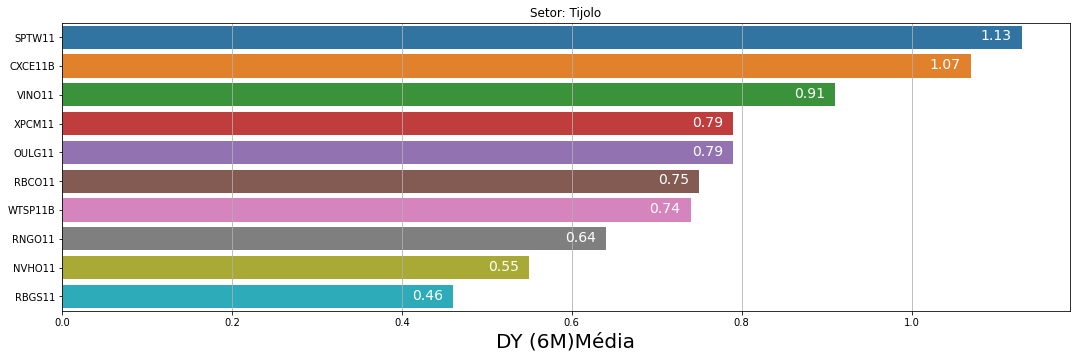

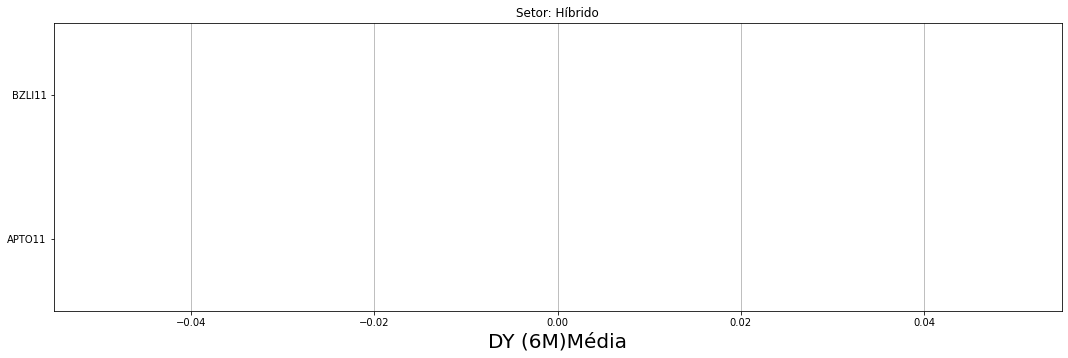

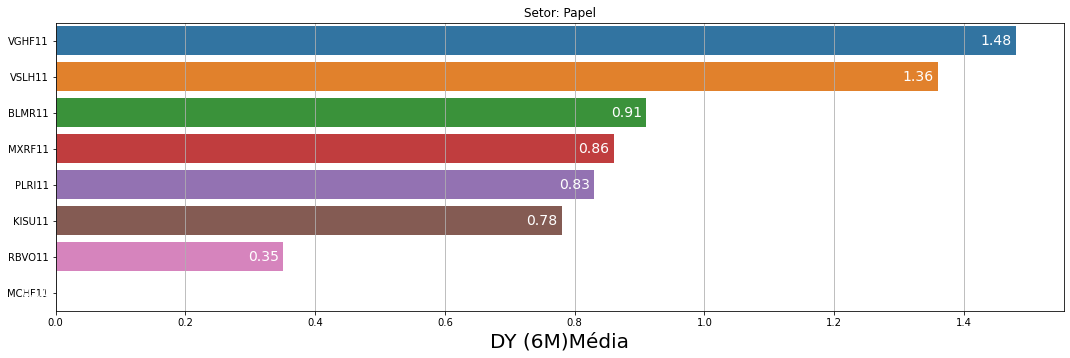

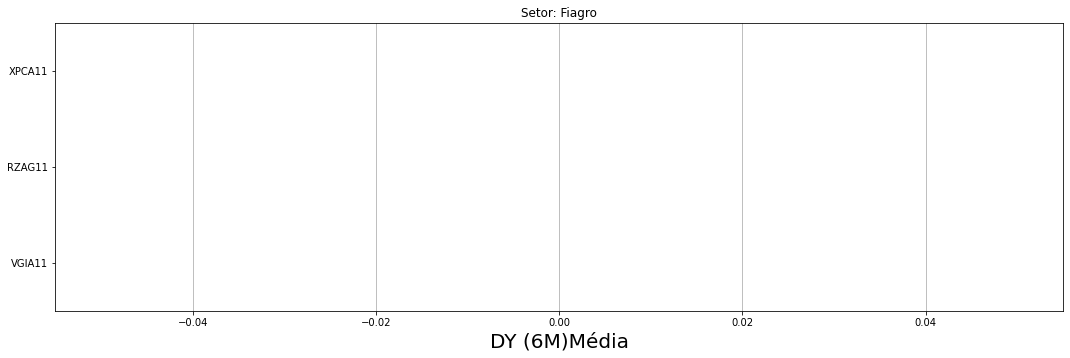

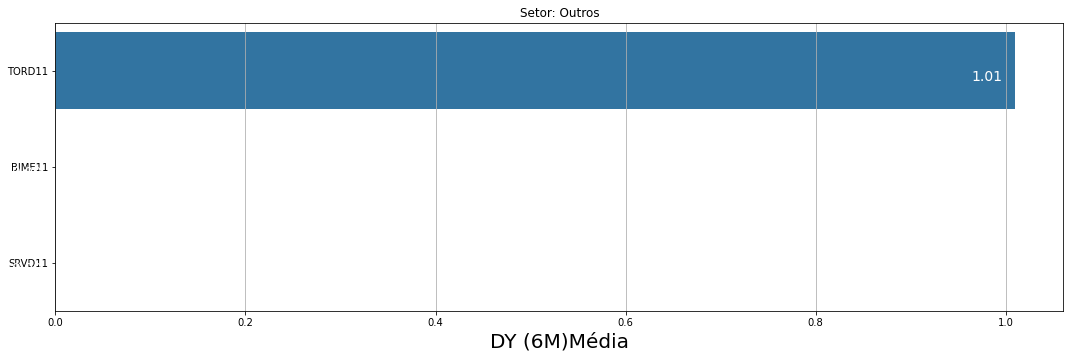

In [ ]:
for setor in dados_1['Setor'].unique():
  selecao = (dados_1['Valor'] < preco ) & (dados_1['Setor'] == setor)
  super_dados = dados_1[selecao].sort_values( ordenador , ascending= False)


  fig = plt.figure(figsize= (14,4))
 

  eixo1 = fig.add_axes([0,0,1,1])
  eixo1.grid(True)



  sns.barplot(x = ordenador, y = 'Códigodo fundo', data = super_dados[0:10], tick_label = True)
  num = -4



  #Colocando rotolo
  for p in eixo1.patches:
    
    height = p.get_height() + 0.3 + num
    eixo1.text(p.get_x()+p.get_width() -0.03,
    height + 3,
    '{:1.2f}'.format((p.get_width())),
    ha='center',
    color = 'w',
    size = 14)
    num += 1

  eixo1.set_ylabel('')
  eixo1.set_xlabel(ordenador ,fontsize = 20)
  plt.title(f'Setor: {setor}')


### Gráfico com sub setor escolhido

In [ ]:
# ['Tijolo' 'Híbrido' 'Papel' 'Outros' 'Fiagro']
Setor = 'Tijolo'
selecao = dados_1['Setor'] == Setor
sub = dados_1[selecao]['Sub-Setor'].unique()

ordenador = 'DY (3M)Média'
preco = 50

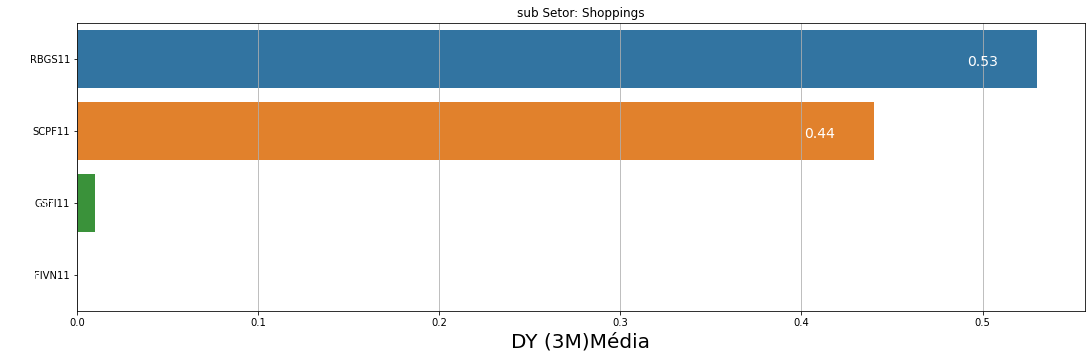

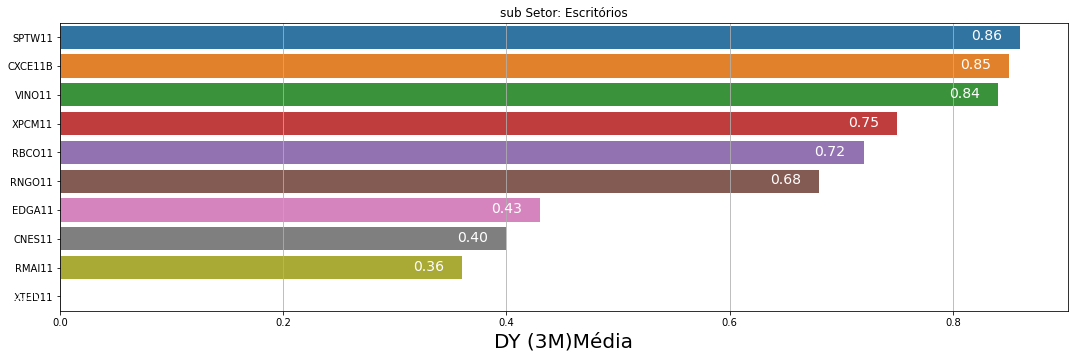

posx and posy should be finite values


posx and posy should be finite values


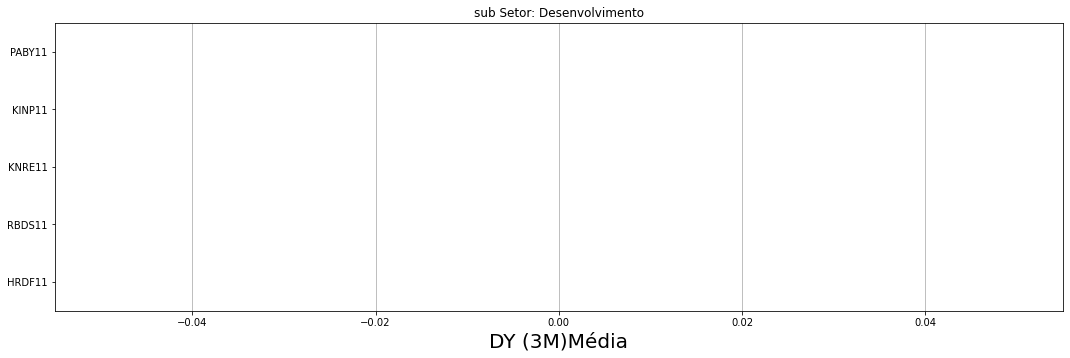

ValueError: ignored

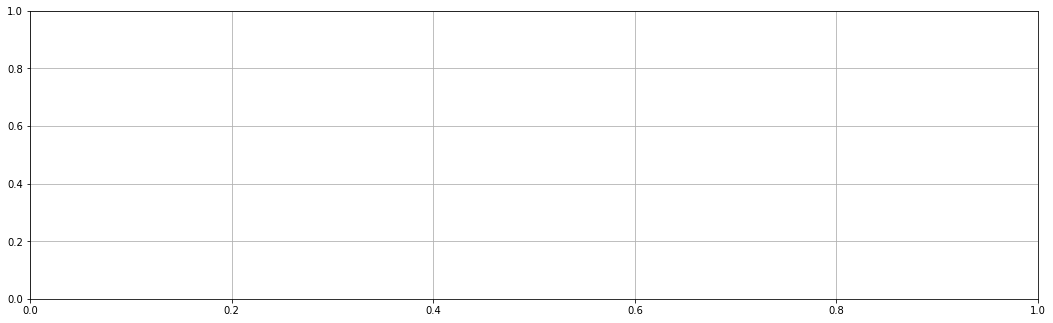

In [ ]:
for sub_setor in sub:
  selecao = (dados_1['Valor'] < preco ) & (dados_1['Sub-Setor'] == sub_setor) 
  super_dados = dados_1[selecao].sort_values( ordenador , ascending= False)


  fig = plt.figure(figsize= (14,4))


  eixo1 = fig.add_axes([0,0,1,1])
  eixo1.grid(True)


  try:
    sns.barplot(x = ordenador, y = 'Códigodo fundo', data = super_dados[0:10], tick_label = True)
    num = -4
  except ValueError as err: 
    print(err)




  #Colocando rotolo
  for p in eixo1.patches:
    
    height = p.get_height() + 0.3 + num
    eixo1.text(p.get_x()+p.get_width() -0.03,
    height + 3,
    '{:1.2f}'.format((p.get_width())),
    ha='center',
    color = 'w',
    size = 14)
    num += 1

  eixo1.set_ylabel('')
  eixo1.set_xlabel(ordenador ,fontsize = 20)
  plt.title(f'sub Setor: {sub_setor}')
  plt.show()
  print('\n')
